In [15]:
import numpy as np
import pandas as pd
import random
import json
import csv
import math
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import urllib
from forecastiopy import *

In [16]:
LA = '34.052235, -118.243683,'
NY = '40.730610, -73.935242,'
PortOr = '45.512794, -122.679565'
API_KEY = '923677cb33071713bf086cd0fef8aac2'

#Variable represents the UNIX time of January 1, 2010
var2010 = 1262360341

#Variable represents the UNIX time of January 1, 2016
var2016 = 1451667071

#Adding this to var2010 will advance the unix time by one day
addADay = 86400

file2 = open('weather.csv', 'wt')

try:
    writer = csv.writer(file2)
    writer.writerow(('PRCP', 'TMAX', 'TMIN', 'SIGLVL'))
    
    
    for i in range(2):
        response = urllib.request.urlopen('https://api.darksky.net/forecast/923677cb33071713bf086cd0fef8aac2/' + PortOr + str(var2010))

        #Converts HTTPResponse object to string
        string = response.read().decode('utf-8')

        #Creates initial json data
        json_obj = json.loads(string)

        #Format json data
        #jsson = json.dumps(json_obj, indent = 4)
        #print(jsson)


        prcp = str(json_obj['daily']['data'][0]['precipIntensity'])
        tmaxx = str(json_obj['daily']['data'][0]['apparentTemperatureMax'])
        tminn = str(json_obj['daily']['data'][0]['apparentTemperatureMin'])
        siglvl = random.randint(60, 70)
        ssiglvl = str(siglvl)
        
        writer.writerow((prcp, tmaxx, tminn, ssiglvl))
        var2010 += addADay
        print(var2010)
finally:
    file2.close()

#Write to json file
#with open('data.json', 'w') as f:
     #json.dump(jsson, f)

1262446741
1262533141


In [219]:
x = pd.read_csv('NY2016weather.csv');
#Add a new column SNR(Signal Noise Ratio) using our formula y = -80x - 20



x['PRCP2'] = x['PRCP'] + x['RAND1']

x['SNR1'] = x['PRCP2'].apply(lambda r: (r * -80) - 20)
x['SNR2'] = x['TMAX'].apply(lambda x: (x * -0.3))

x['SNR'] = x['SNR1'] + x['SNR2']


#print(x)

In [220]:
prcpMax = x['PRCP2'].max()
sigMax = x['SIGLVL'].max()



tempMax = x['TMAX'].max()

tempMinMax = x['TMIN'].max()
tempMinMin = x['TMIN'].min()

x['NormPRCP'] = x['PRCP2'].apply(lambda y: y / prcpMax)
x['RPRCP'] = x['NormPRCP'].apply(lambda a: (abs(a - 0.5)) + 0.99)

#print(x['RAND2'])

x['RAND2'] = x['RAND2'] / x['RPRCP']

x['NSNR'] = x['SNR'] + x['RAND2']

snrMax = x['NSNR'].max()
snrMin = x['NSNR'].min()

x['NormTMAX'] = x['TMAX'].apply(lambda u: u / tempMax)

x['NormTMIN'] = x['TMIN'].apply(lambda e: (e - tempMinMin)/(tempMinMax - tempMinMin))

x['NormSNR'] = x['NSNR'].apply(lambda d: (d - snrMin)/ (snrMax - snrMin))

x['logPRCP'] = x['PRCP'].apply(lambda i: math.log10(((i + 0.01) ** (1 / 3)) + 2 ))
#x['logSNR'] = x['NormSNR'].apply(lambda p: math.log10((p ** (1 / 2)) + 10))

#x['logPRCP'] = x['NormPRCP'].apply(lambda i: math.log2(i + 2))
#x['logSNR'] = x['NormSNR'].apply(lambda p: math.log2(p + 2))

#x['logPRCP'] = x['NormPRCP'].apply(lambda i: (i ** 2))
x['logSNR'] = x['NormSNR'].apply(lambda p: ((p + 0.01) ** 3) )


#print(x[['NormPRCP', 'RPRCP', 'RAND2']])

<function matplotlib.pyplot.show>

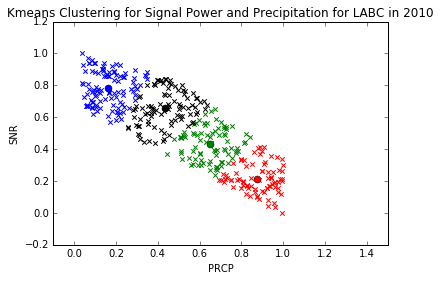

In [222]:
%matplotlib inline
kMeans = KMeans(n_clusters=4)
X = x[['NormPRCP', 'NormSNR']]
kMeans.fit(X)

# Assigned Labels after clustering: 
labels = kMeans.labels_

# Centers of the clusters:
centers = kMeans.cluster_centers_

plt.figure

for l, c in zip([0,1,2,3], ['red', 'blue', 'green', 'black']):
    
    current_members = (labels == l)
    current_center = centers[l]
    
    plt.scatter(X.iloc[current_members,0], X.iloc[current_members,1], color = c, marker='x')
    
    plt.plot(current_center[0], current_center[1], 'o', markerfacecolor = c,
            markeredgecolor = 'k', markersize=7)
    
plt.xlim([-0.1,1.5])

    
plt.xlabel('PRCP')
plt.ylabel('SNR')
plt.title('Kmeans Clustering for Signal Power and Precipitation for LABC in 2010')

plt.show

In [191]:
stdMeanFeats = ['NormTMIN', 'logPRCP', 'logSNR', 'NormTMAX']
# stdMeanFeats = ['logPRCP', 'logSNR']
print("Standard Deviation:")
print(x[stdMeanFeats].std())

print("\nMean:")
print(x[stdMeanFeats].mean())


x['logSNR'] = x['logSNR'].apply(lambda p: ((p - x['logSNR'].mean())/ (x['logSNR'].std())))
x['logPRCP'] = x['logPRCP'].apply(lambda p: ((p - x['logPRCP'].mean())/ (x['logPRCP'].std())))
x['NormTMIN'] = x['NormTMIN'].apply(lambda p: ((p - x['NormTMIN'].mean())/ (x['NormTMIN'].std())))
x['NormTMAX'] = x['NormTMAX'].apply(lambda p: ((p - x['NormTMAX'].mean())/ (x['NormTMAX'].std())))

#NDvalues stores the normal distribution values of PRCP, then SNOW, then TMAX, etc.
i = 0
# NDvalues = [0, 0, 0, 0, 0, 0, 0]
NDvalues = [0,0,0,0]
for name in stdMeanFeats:
    z = 100
    e = 2.71
    denominator = math.sqrt(2 * (math.pow(x[name].std(), 2)) * math.pi) 
    numeratorOfPower = math.pow((z - x[name].mean()), 2)
    denominatorOfPower = 2 * math.pow(x[name].std(), 2)
    power = numeratorOfPower / denominatorOfPower
    power *= -1
    finalbase = e / denominator
    NDvalues[i] = math.pow(finalbase, (power))
    i += 1

i = 0
print('\n')
print('Normal Distribution Values \n')
for value in NDvalues:
    print(str(stdMeanFeats[i]) + '      ' + str(NDvalues[i]))
    i += 1
finalValue = 1
for number in NDvalues:
    finalValue *= number
print()
print('Probability: ' + str(finalValue))

Standard Deviation:
NormTMIN    0.193582
logPRCP     0.007331
logSNR      0.240534
NormTMAX    0.192248
dtype: float64

Mean:
NormTMIN    0.629635
logPRCP     0.348662
logSNR      0.260963
NormTMAX    0.593391
dtype: float64


Normal Distribution Values 

NormTMIN      4.0106662486048414e-170
logPRCP      4.010666248584519e-170
logSNR      4.010666248609529e-170
NormTMAX      4.0106662486183355e-170

Probability: 0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000ACC52B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000000ACCEA90>]], dtype=object)

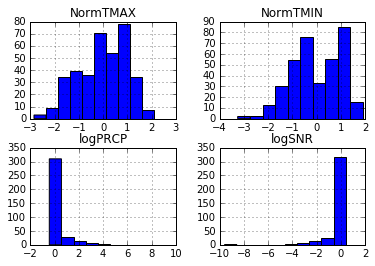

In [10]:
%matplotlib inline

plt.figure

x[stdMeanFeats].hist(bins=10)